In [ ]:
%cd /content/drive/My Drive/nlp_jcomp


/content/drive/My Drive/nlp_jcomp


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile

TensorFlow 1.x selected.


In [ ]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [ ]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [ ]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
#unzip_single_file(snli_zip_file, snli_dev_file)
unzip_single_file(snli_zip_file, snli_full_dataset_file)

In [ ]:
glove_wordmap = {}
with open(glove_vectors_file, "r") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [ ]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

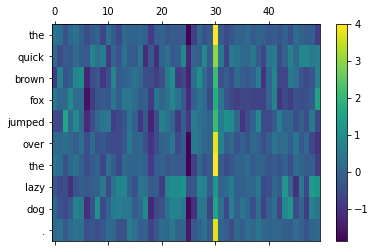

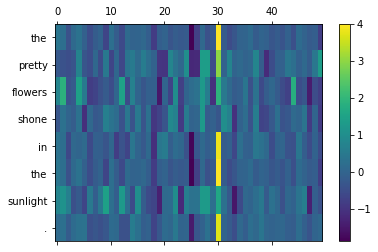

In [ ]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

In [ ]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [ ]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 900000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [ ]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_train.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        i=0
        for row in train:
            if(i>250000):
              break
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
            i=i+1
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:



In [ ]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using TensorFlow as follows:

In [ ]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [ ]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

In [ ]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|          | 7/7032 [00:01<2:23:51,  1.23s/it]

Iter 0.0, Minibatch Loss= 1.106455, Training Accuracy= 0.38281


  0%|          | 19/7032 [00:02<1:11:28,  1.64it/s]

Iter 10.0, Minibatch Loss= 1.083580, Training Accuracy= 0.39844
Iter 20.0, Minibatch Loss= 1.089930, Training Accuracy= 0.35938


  1%|          | 38/7032 [00:02<25:48,  4.52it/s]

Iter 30.0, Minibatch Loss= 1.086658, Training Accuracy= 0.38281
Iter 40.0, Minibatch Loss= 1.065046, Training Accuracy= 0.46094


  1%|          | 62/7032 [00:02<07:48, 14.87it/s]

Iter 50.0, Minibatch Loss= 1.085826, Training Accuracy= 0.39844
Iter 60.0, Minibatch Loss= 1.050301, Training Accuracy= 0.39844


  1%|          | 81/7032 [00:03<04:05, 28.28it/s]

Iter 70.0, Minibatch Loss= 1.052542, Training Accuracy= 0.43750
Iter 80.0, Minibatch Loss= 1.092652, Training Accuracy= 0.35938


  1%|▏         | 100/7032 [00:03<02:43, 42.52it/s]

Iter 90.0, Minibatch Loss= 1.080248, Training Accuracy= 0.42969
Iter 100.0, Minibatch Loss= 1.072450, Training Accuracy= 0.42188


  2%|▏         | 119/7032 [00:03<02:18, 49.97it/s]

Iter 110.0, Minibatch Loss= 1.084717, Training Accuracy= 0.42188
Iter 120.0, Minibatch Loss= 1.077183, Training Accuracy= 0.45312


  2%|▏         | 137/7032 [00:04<02:14, 51.08it/s]

Iter 130.0, Minibatch Loss= 1.071854, Training Accuracy= 0.42969
Iter 140.0, Minibatch Loss= 1.088138, Training Accuracy= 0.37500


  2%|▏         | 162/7032 [00:04<02:11, 52.15it/s]

Iter 150.0, Minibatch Loss= 1.056226, Training Accuracy= 0.49219
Iter 160.0, Minibatch Loss= 1.074074, Training Accuracy= 0.44531


  3%|▎         | 180/7032 [00:05<02:03, 55.27it/s]

Iter 170.0, Minibatch Loss= 1.070309, Training Accuracy= 0.42188
Iter 180.0, Minibatch Loss= 1.060140, Training Accuracy= 0.47656


  3%|▎         | 198/7032 [00:05<02:06, 54.18it/s]

Iter 190.0, Minibatch Loss= 1.071332, Training Accuracy= 0.43750
Iter 200.0, Minibatch Loss= 1.061526, Training Accuracy= 0.44531


  3%|▎         | 217/7032 [00:05<02:04, 54.71it/s]

Iter 210.0, Minibatch Loss= 1.014021, Training Accuracy= 0.49219
Iter 220.0, Minibatch Loss= 1.071045, Training Accuracy= 0.43750


  3%|▎         | 242/7032 [00:06<02:05, 54.18it/s]

Iter 230.0, Minibatch Loss= 1.068690, Training Accuracy= 0.43750
Iter 240.0, Minibatch Loss= 1.045738, Training Accuracy= 0.47656


  4%|▎         | 261/7032 [00:06<02:05, 54.13it/s]

Iter 250.0, Minibatch Loss= 1.046052, Training Accuracy= 0.42188
Iter 260.0, Minibatch Loss= 1.078729, Training Accuracy= 0.41406


  4%|▍         | 280/7032 [00:06<02:00, 55.84it/s]

Iter 270.0, Minibatch Loss= 1.036639, Training Accuracy= 0.42969
Iter 280.0, Minibatch Loss= 1.041909, Training Accuracy= 0.45312


  4%|▍         | 299/7032 [00:07<02:02, 55.14it/s]

Iter 290.0, Minibatch Loss= 1.050698, Training Accuracy= 0.45312
Iter 300.0, Minibatch Loss= 1.053902, Training Accuracy= 0.41406


  5%|▍         | 318/7032 [00:07<02:00, 55.72it/s]

Iter 310.0, Minibatch Loss= 1.035150, Training Accuracy= 0.48438
Iter 320.0, Minibatch Loss= 1.094377, Training Accuracy= 0.37500


  5%|▍         | 337/7032 [00:07<02:01, 55.29it/s]

Iter 330.0, Minibatch Loss= 1.059654, Training Accuracy= 0.44531
Iter 340.0, Minibatch Loss= 1.062624, Training Accuracy= 0.41406


  5%|▌         | 362/7032 [00:08<02:04, 53.67it/s]

Iter 350.0, Minibatch Loss= 0.972803, Training Accuracy= 0.56250
Iter 360.0, Minibatch Loss= 1.051413, Training Accuracy= 0.46875


  5%|▌         | 380/7032 [00:08<02:01, 54.93it/s]

Iter 370.0, Minibatch Loss= 1.053135, Training Accuracy= 0.42969
Iter 380.0, Minibatch Loss= 1.053483, Training Accuracy= 0.42188


  6%|▌         | 399/7032 [00:09<01:58, 56.12it/s]

Iter 390.0, Minibatch Loss= 1.062310, Training Accuracy= 0.42188
Iter 400.0, Minibatch Loss= 1.012005, Training Accuracy= 0.49219


  6%|▌         | 417/7032 [00:09<01:58, 55.67it/s]

Iter 410.0, Minibatch Loss= 1.071199, Training Accuracy= 0.39844
Iter 420.0, Minibatch Loss= 1.042597, Training Accuracy= 0.45312


  6%|▋         | 442/7032 [00:09<02:02, 53.81it/s]

Iter 430.0, Minibatch Loss= 1.020812, Training Accuracy= 0.42969
Iter 440.0, Minibatch Loss= 0.974569, Training Accuracy= 0.53125


  7%|▋         | 460/7032 [00:10<01:58, 55.26it/s]

Iter 450.0, Minibatch Loss= 0.980146, Training Accuracy= 0.51562
Iter 460.0, Minibatch Loss= 1.023032, Training Accuracy= 0.43750


  7%|▋         | 479/7032 [00:10<01:58, 55.32it/s]

Iter 470.0, Minibatch Loss= 1.032152, Training Accuracy= 0.48438
Iter 480.0, Minibatch Loss= 0.958850, Training Accuracy= 0.52344


  7%|▋         | 498/7032 [00:10<01:59, 54.77it/s]

Iter 490.0, Minibatch Loss= 1.077400, Training Accuracy= 0.42969
Iter 500.0, Minibatch Loss= 0.993255, Training Accuracy= 0.50781


  7%|▋         | 518/7032 [00:11<01:55, 56.21it/s]

Iter 510.0, Minibatch Loss= 1.074281, Training Accuracy= 0.42188
Iter 520.0, Minibatch Loss= 1.069513, Training Accuracy= 0.42188


  8%|▊         | 538/7032 [00:11<01:55, 56.29it/s]

Iter 530.0, Minibatch Loss= 0.991108, Training Accuracy= 0.53906
Iter 540.0, Minibatch Loss= 1.047689, Training Accuracy= 0.46875


  8%|▊         | 562/7032 [00:12<01:59, 54.34it/s]

Iter 550.0, Minibatch Loss= 1.057602, Training Accuracy= 0.42969
Iter 560.0, Minibatch Loss= 1.056226, Training Accuracy= 0.42188


  8%|▊         | 581/7032 [00:12<01:58, 54.61it/s]

Iter 570.0, Minibatch Loss= 1.071886, Training Accuracy= 0.45312
Iter 580.0, Minibatch Loss= 1.073423, Training Accuracy= 0.40625


  9%|▊         | 600/7032 [00:12<01:53, 56.51it/s]

Iter 590.0, Minibatch Loss= 1.026242, Training Accuracy= 0.44531
Iter 600.0, Minibatch Loss= 1.074946, Training Accuracy= 0.44531


  9%|▉         | 619/7032 [00:13<01:57, 54.58it/s]

Iter 610.0, Minibatch Loss= 1.035722, Training Accuracy= 0.46875
Iter 620.0, Minibatch Loss= 1.045319, Training Accuracy= 0.43750


  9%|▉         | 637/7032 [00:13<01:55, 55.28it/s]

Iter 630.0, Minibatch Loss= 1.069443, Training Accuracy= 0.37500
Iter 640.0, Minibatch Loss= 0.975567, Training Accuracy= 0.50781


  9%|▉         | 656/7032 [00:13<01:55, 55.41it/s]

Iter 650.0, Minibatch Loss= 1.071786, Training Accuracy= 0.37500
Iter 660.0, Minibatch Loss= 1.026979, Training Accuracy= 0.44531


 10%|▉         | 681/7032 [00:14<01:57, 54.19it/s]

Iter 670.0, Minibatch Loss= 1.005992, Training Accuracy= 0.55469
Iter 680.0, Minibatch Loss= 1.047064, Training Accuracy= 0.45312


 10%|▉         | 699/7032 [00:14<01:56, 54.32it/s]

Iter 690.0, Minibatch Loss= 1.032351, Training Accuracy= 0.52344
Iter 700.0, Minibatch Loss= 1.009290, Training Accuracy= 0.51562


 10%|█         | 717/7032 [00:14<01:56, 54.41it/s]

Iter 710.0, Minibatch Loss= 1.052117, Training Accuracy= 0.42188
Iter 720.0, Minibatch Loss= 1.026399, Training Accuracy= 0.50000


 11%|█         | 741/7032 [00:15<01:59, 52.47it/s]

Iter 730.0, Minibatch Loss= 1.024727, Training Accuracy= 0.42188
Iter 740.0, Minibatch Loss= 1.036466, Training Accuracy= 0.53125


 11%|█         | 759/7032 [00:15<01:53, 55.20it/s]

Iter 750.0, Minibatch Loss= 1.013408, Training Accuracy= 0.46094
Iter 760.0, Minibatch Loss= 1.037838, Training Accuracy= 0.42188


 11%|█         | 777/7032 [00:15<01:57, 53.45it/s]

Iter 770.0, Minibatch Loss= 1.034823, Training Accuracy= 0.50000
Iter 780.0, Minibatch Loss= 1.056607, Training Accuracy= 0.47656


 11%|█▏        | 802/7032 [00:16<01:56, 53.25it/s]

Iter 790.0, Minibatch Loss= 0.998431, Training Accuracy= 0.43750
Iter 800.0, Minibatch Loss= 1.079121, Training Accuracy= 0.40625


 12%|█▏        | 821/7032 [00:16<01:56, 53.25it/s]

Iter 810.0, Minibatch Loss= 1.011495, Training Accuracy= 0.50000
Iter 820.0, Minibatch Loss= 1.010080, Training Accuracy= 0.49219


 12%|█▏        | 840/7032 [00:17<01:51, 55.34it/s]

Iter 830.0, Minibatch Loss= 0.971198, Training Accuracy= 0.54688
Iter 840.0, Minibatch Loss= 1.028799, Training Accuracy= 0.46875


 12%|█▏        | 859/7032 [00:17<01:53, 54.34it/s]

Iter 850.0, Minibatch Loss= 1.067636, Training Accuracy= 0.43750
Iter 860.0, Minibatch Loss= 1.005297, Training Accuracy= 0.47656


 12%|█▏        | 877/7032 [00:17<01:52, 54.81it/s]

Iter 870.0, Minibatch Loss= 0.996667, Training Accuracy= 0.47656
Iter 880.0, Minibatch Loss= 1.035959, Training Accuracy= 0.44531


 13%|█▎        | 902/7032 [00:18<01:54, 53.41it/s]

Iter 890.0, Minibatch Loss= 1.029307, Training Accuracy= 0.46875
Iter 900.0, Minibatch Loss= 0.999659, Training Accuracy= 0.50781


 13%|█▎        | 921/7032 [00:18<01:53, 53.87it/s]

Iter 910.0, Minibatch Loss= 1.023153, Training Accuracy= 0.49219
Iter 920.0, Minibatch Loss= 0.973334, Training Accuracy= 0.55469


 13%|█▎        | 941/7032 [00:19<01:54, 53.20it/s]

Iter 930.0, Minibatch Loss= 1.016526, Training Accuracy= 0.44531
Iter 940.0, Minibatch Loss= 0.929217, Training Accuracy= 0.54688


 14%|█▎        | 960/7032 [00:19<01:48, 55.76it/s]

Iter 950.0, Minibatch Loss= 1.021712, Training Accuracy= 0.47656
Iter 960.0, Minibatch Loss= 1.070718, Training Accuracy= 0.47656


 14%|█▍        | 979/7032 [00:19<01:49, 55.39it/s]

Iter 970.0, Minibatch Loss= 1.022300, Training Accuracy= 0.47656
Iter 980.0, Minibatch Loss= 1.044725, Training Accuracy= 0.45312


 14%|█▍        | 997/7032 [00:20<01:51, 53.95it/s]

Iter 990.0, Minibatch Loss= 1.026851, Training Accuracy= 0.51562
Iter 1000.0, Minibatch Loss= 0.980976, Training Accuracy= 0.51562


 14%|█▍        | 1016/7032 [00:20<01:50, 54.21it/s]

Iter 1010.0, Minibatch Loss= 1.039326, Training Accuracy= 0.43750
Iter 1020.0, Minibatch Loss= 1.015016, Training Accuracy= 0.51562


 15%|█▍        | 1040/7032 [00:20<01:48, 55.03it/s]

Iter 1030.0, Minibatch Loss= 1.014256, Training Accuracy= 0.43750
Iter 1040.0, Minibatch Loss= 0.986557, Training Accuracy= 0.51562


 15%|█▌        | 1059/7032 [00:21<01:49, 54.53it/s]

Iter 1050.0, Minibatch Loss= 1.019604, Training Accuracy= 0.48438
Iter 1060.0, Minibatch Loss= 1.050355, Training Accuracy= 0.46094


 15%|█▌        | 1077/7032 [00:21<01:49, 54.42it/s]

Iter 1070.0, Minibatch Loss= 0.949358, Training Accuracy= 0.55469
Iter 1080.0, Minibatch Loss= 0.985227, Training Accuracy= 0.53906


 16%|█▌        | 1101/7032 [00:21<01:51, 53.19it/s]

Iter 1090.0, Minibatch Loss= 0.993582, Training Accuracy= 0.53125
Iter 1100.0, Minibatch Loss= 1.031642, Training Accuracy= 0.48438


 16%|█▌        | 1120/7032 [00:22<01:45, 55.88it/s]

Iter 1110.0, Minibatch Loss= 1.001605, Training Accuracy= 0.50781
Iter 1120.0, Minibatch Loss= 1.006814, Training Accuracy= 0.48438


 16%|█▌        | 1138/7032 [00:22<01:46, 55.33it/s]

Iter 1130.0, Minibatch Loss= 0.975597, Training Accuracy= 0.50000
Iter 1140.0, Minibatch Loss= 0.997636, Training Accuracy= 0.46875


 16%|█▋        | 1158/7032 [00:23<01:46, 55.08it/s]

Iter 1150.0, Minibatch Loss= 0.973661, Training Accuracy= 0.56250
Iter 1160.0, Minibatch Loss= 0.977559, Training Accuracy= 0.49219


 17%|█▋        | 1177/7032 [00:23<01:48, 54.21it/s]

Iter 1170.0, Minibatch Loss= 0.939805, Training Accuracy= 0.51562
Iter 1180.0, Minibatch Loss= 0.988748, Training Accuracy= 0.53906


 17%|█▋        | 1202/7032 [00:23<01:47, 54.43it/s]

Iter 1190.0, Minibatch Loss= 0.999221, Training Accuracy= 0.45312
Iter 1200.0, Minibatch Loss= 0.961444, Training Accuracy= 0.53906


 17%|█▋        | 1221/7032 [00:24<01:48, 53.66it/s]

Iter 1210.0, Minibatch Loss= 0.960524, Training Accuracy= 0.53906
Iter 1220.0, Minibatch Loss= 1.036701, Training Accuracy= 0.46875


 18%|█▊        | 1240/7032 [00:24<01:43, 55.89it/s]

Iter 1230.0, Minibatch Loss= 0.963822, Training Accuracy= 0.50781
Iter 1240.0, Minibatch Loss= 0.923737, Training Accuracy= 0.57031


 18%|█▊        | 1259/7032 [00:24<01:42, 56.19it/s]

Iter 1250.0, Minibatch Loss= 0.924348, Training Accuracy= 0.53906
Iter 1260.0, Minibatch Loss= 0.938392, Training Accuracy= 0.53906


 18%|█▊        | 1277/7032 [00:25<01:45, 54.31it/s]

Iter 1270.0, Minibatch Loss= 1.011634, Training Accuracy= 0.46094
Iter 1280.0, Minibatch Loss= 0.941500, Training Accuracy= 0.53125


 19%|█▊        | 1301/7032 [00:25<01:48, 52.68it/s]

Iter 1290.0, Minibatch Loss= 0.978203, Training Accuracy= 0.53906
Iter 1300.0, Minibatch Loss= 0.988027, Training Accuracy= 0.48438


 19%|█▉        | 1319/7032 [00:25<01:44, 54.86it/s]

Iter 1310.0, Minibatch Loss= 1.004510, Training Accuracy= 0.47656
Iter 1320.0, Minibatch Loss= 0.913505, Training Accuracy= 0.60938


 19%|█▉        | 1337/7032 [00:26<01:44, 54.55it/s]

Iter 1330.0, Minibatch Loss= 0.927683, Training Accuracy= 0.59375
Iter 1340.0, Minibatch Loss= 0.976382, Training Accuracy= 0.54688


 19%|█▉        | 1362/7032 [00:26<01:44, 54.48it/s]

Iter 1350.0, Minibatch Loss= 0.919285, Training Accuracy= 0.54688
Iter 1360.0, Minibatch Loss= 0.942429, Training Accuracy= 0.60938


 20%|█▉        | 1381/7032 [00:27<01:44, 54.01it/s]

Iter 1370.0, Minibatch Loss= 0.940618, Training Accuracy= 0.55469
Iter 1380.0, Minibatch Loss= 0.999237, Training Accuracy= 0.52344


 20%|█▉        | 1400/7032 [00:27<01:40, 56.19it/s]

Iter 1390.0, Minibatch Loss= 0.967229, Training Accuracy= 0.51562
Iter 1400.0, Minibatch Loss= 0.936311, Training Accuracy= 0.56250


 20%|██        | 1419/7032 [00:27<01:40, 55.74it/s]

Iter 1410.0, Minibatch Loss= 0.972522, Training Accuracy= 0.54688
Iter 1420.0, Minibatch Loss= 0.983803, Training Accuracy= 0.54688


 20%|██        | 1438/7032 [00:28<01:41, 55.34it/s]

Iter 1430.0, Minibatch Loss= 0.960939, Training Accuracy= 0.50781
Iter 1440.0, Minibatch Loss= 1.025290, Training Accuracy= 0.48438


 21%|██        | 1458/7032 [00:28<01:39, 55.89it/s]

Iter 1450.0, Minibatch Loss= 0.920461, Training Accuracy= 0.56250
Iter 1460.0, Minibatch Loss= 1.027102, Training Accuracy= 0.48438


 21%|██        | 1476/7032 [00:28<01:42, 54.09it/s]

Iter 1470.0, Minibatch Loss= 0.938288, Training Accuracy= 0.53125
Iter 1480.0, Minibatch Loss= 0.956278, Training Accuracy= 0.53125


 21%|██▏       | 1501/7032 [00:29<01:43, 53.31it/s]

Iter 1490.0, Minibatch Loss= 0.913912, Training Accuracy= 0.53906
Iter 1500.0, Minibatch Loss= 0.971040, Training Accuracy= 0.55469


 22%|██▏       | 1520/7032 [00:29<01:36, 56.99it/s]

Iter 1510.0, Minibatch Loss= 1.029335, Training Accuracy= 0.42969
Iter 1520.0, Minibatch Loss= 0.935085, Training Accuracy= 0.53906


 22%|██▏       | 1538/7032 [00:29<01:38, 55.87it/s]

Iter 1530.0, Minibatch Loss= 0.862995, Training Accuracy= 0.58594
Iter 1540.0, Minibatch Loss= 0.987684, Training Accuracy= 0.53125


 22%|██▏       | 1558/7032 [00:30<01:37, 56.25it/s]

Iter 1550.0, Minibatch Loss= 0.934134, Training Accuracy= 0.57812
Iter 1560.0, Minibatch Loss= 0.968083, Training Accuracy= 0.53125


 22%|██▏       | 1578/7032 [00:30<01:35, 56.82it/s]

Iter 1570.0, Minibatch Loss= 0.949517, Training Accuracy= 0.57031
Iter 1580.0, Minibatch Loss= 0.979954, Training Accuracy= 0.55469


 23%|██▎       | 1597/7032 [00:31<01:38, 55.04it/s]

Iter 1590.0, Minibatch Loss= 0.925807, Training Accuracy= 0.53906
Iter 1600.0, Minibatch Loss= 0.926081, Training Accuracy= 0.53906


 23%|██▎       | 1621/7032 [00:31<01:43, 52.18it/s]

Iter 1610.0, Minibatch Loss= 0.981108, Training Accuracy= 0.53906
Iter 1620.0, Minibatch Loss= 0.969537, Training Accuracy= 0.59375


 23%|██▎       | 1640/7032 [00:31<01:36, 56.15it/s]

Iter 1630.0, Minibatch Loss= 0.990999, Training Accuracy= 0.53125
Iter 1640.0, Minibatch Loss= 1.044818, Training Accuracy= 0.48438


 24%|██▎       | 1659/7032 [00:32<01:36, 55.82it/s]

Iter 1650.0, Minibatch Loss= 0.996635, Training Accuracy= 0.52344
Iter 1660.0, Minibatch Loss= 0.940918, Training Accuracy= 0.54688


 24%|██▍       | 1678/7032 [00:32<01:35, 56.20it/s]

Iter 1670.0, Minibatch Loss= 0.902253, Training Accuracy= 0.61719
Iter 1680.0, Minibatch Loss= 0.902939, Training Accuracy= 0.62500


 24%|██▍       | 1698/7032 [00:32<01:32, 57.39it/s]

Iter 1690.0, Minibatch Loss= 0.944024, Training Accuracy= 0.54688
Iter 1700.0, Minibatch Loss= 0.974800, Training Accuracy= 0.53125


 24%|██▍       | 1722/7032 [00:33<01:38, 54.09it/s]

Iter 1710.0, Minibatch Loss= 0.885723, Training Accuracy= 0.62500
Iter 1720.0, Minibatch Loss= 1.000138, Training Accuracy= 0.53125


 25%|██▍       | 1741/7032 [00:33<01:36, 54.60it/s]

Iter 1730.0, Minibatch Loss= 0.982017, Training Accuracy= 0.51562
Iter 1740.0, Minibatch Loss= 0.915064, Training Accuracy= 0.56250


 25%|██▌       | 1761/7032 [00:34<01:35, 55.06it/s]

Iter 1750.0, Minibatch Loss= 0.941046, Training Accuracy= 0.51562
Iter 1760.0, Minibatch Loss= 0.889307, Training Accuracy= 0.58594


 25%|██▌       | 1780/7032 [00:34<01:31, 57.17it/s]

Iter 1770.0, Minibatch Loss= 0.889764, Training Accuracy= 0.60938
Iter 1780.0, Minibatch Loss= 0.952341, Training Accuracy= 0.52344


 26%|██▌       | 1798/7032 [00:34<01:33, 56.09it/s]

Iter 1790.0, Minibatch Loss= 0.950309, Training Accuracy= 0.57812
Iter 1800.0, Minibatch Loss= 0.866435, Training Accuracy= 0.58594


 26%|██▌       | 1818/7032 [00:35<01:31, 57.07it/s]

Iter 1810.0, Minibatch Loss= 0.881776, Training Accuracy= 0.60938
Iter 1820.0, Minibatch Loss= 0.962522, Training Accuracy= 0.54688


 26%|██▌       | 1838/7032 [00:35<01:31, 56.51it/s]

Iter 1830.0, Minibatch Loss= 0.910488, Training Accuracy= 0.60156
Iter 1840.0, Minibatch Loss= 0.924220, Training Accuracy= 0.53906


 26%|██▋       | 1857/7032 [00:35<01:33, 55.16it/s]

Iter 1850.0, Minibatch Loss= 0.933799, Training Accuracy= 0.57812
Iter 1860.0, Minibatch Loss= 0.902790, Training Accuracy= 0.57812


 27%|██▋       | 1876/7032 [00:36<01:35, 54.15it/s]

Iter 1870.0, Minibatch Loss= 0.915882, Training Accuracy= 0.57812
Iter 1880.0, Minibatch Loss= 0.956934, Training Accuracy= 0.50000


 27%|██▋       | 1901/7032 [00:36<01:36, 52.90it/s]

Iter 1890.0, Minibatch Loss= 0.991171, Training Accuracy= 0.52344
Iter 1900.0, Minibatch Loss= 0.957645, Training Accuracy= 0.57031


 27%|██▋       | 1920/7032 [00:36<01:32, 55.30it/s]

Iter 1910.0, Minibatch Loss= 0.997586, Training Accuracy= 0.50000
Iter 1920.0, Minibatch Loss= 0.860582, Training Accuracy= 0.68750


 28%|██▊       | 1939/7032 [00:37<01:33, 54.75it/s]

Iter 1930.0, Minibatch Loss= 0.862913, Training Accuracy= 0.61719
Iter 1940.0, Minibatch Loss= 1.019801, Training Accuracy= 0.58594


 28%|██▊       | 1958/7032 [00:37<01:32, 54.92it/s]

Iter 1950.0, Minibatch Loss= 0.862687, Training Accuracy= 0.58594
Iter 1960.0, Minibatch Loss= 0.891817, Training Accuracy= 0.60156


 28%|██▊       | 1978/7032 [00:37<01:30, 56.13it/s]

Iter 1970.0, Minibatch Loss= 0.978128, Training Accuracy= 0.53125
Iter 1980.0, Minibatch Loss= 0.848080, Training Accuracy= 0.64844


 28%|██▊       | 2002/7032 [00:38<01:34, 53.18it/s]

Iter 1990.0, Minibatch Loss= 0.915462, Training Accuracy= 0.53906
Iter 2000.0, Minibatch Loss= 1.046527, Training Accuracy= 0.48438


 29%|██▊       | 2021/7032 [00:38<01:32, 53.98it/s]

Iter 2010.0, Minibatch Loss= 0.860758, Training Accuracy= 0.61719
Iter 2020.0, Minibatch Loss= 0.879861, Training Accuracy= 0.64062


 29%|██▉       | 2041/7032 [00:39<01:31, 54.35it/s]

Iter 2030.0, Minibatch Loss= 0.961970, Training Accuracy= 0.57812
Iter 2040.0, Minibatch Loss= 0.866984, Training Accuracy= 0.63281


 29%|██▉       | 2060/7032 [00:39<01:27, 56.70it/s]

Iter 2050.0, Minibatch Loss= 0.951385, Training Accuracy= 0.59375
Iter 2060.0, Minibatch Loss= 0.906149, Training Accuracy= 0.59375


 30%|██▉       | 2079/7032 [00:39<01:26, 57.29it/s]

Iter 2070.0, Minibatch Loss= 0.873694, Training Accuracy= 0.63281
Iter 2080.0, Minibatch Loss= 0.884314, Training Accuracy= 0.58594


 30%|██▉       | 2097/7032 [00:40<01:29, 55.41it/s]

Iter 2090.0, Minibatch Loss= 0.935545, Training Accuracy= 0.57812
Iter 2100.0, Minibatch Loss= 0.925709, Training Accuracy= 0.57812


 30%|███       | 2121/7032 [00:40<01:30, 54.43it/s]

Iter 2110.0, Minibatch Loss= 0.897560, Training Accuracy= 0.57812
Iter 2120.0, Minibatch Loss= 0.974550, Training Accuracy= 0.50000


 30%|███       | 2141/7032 [00:40<01:28, 55.08it/s]

Iter 2130.0, Minibatch Loss= 0.924572, Training Accuracy= 0.57031
Iter 2140.0, Minibatch Loss= 0.909261, Training Accuracy= 0.56250


 31%|███       | 2161/7032 [00:41<01:28, 55.04it/s]

Iter 2150.0, Minibatch Loss= 0.923197, Training Accuracy= 0.55469
Iter 2160.0, Minibatch Loss= 0.879530, Training Accuracy= 0.63281


 31%|███       | 2180/7032 [00:41<01:26, 56.03it/s]

Iter 2170.0, Minibatch Loss= 0.931035, Training Accuracy= 0.58594
Iter 2180.0, Minibatch Loss= 0.921391, Training Accuracy= 0.54688


 31%|███▏      | 2199/7032 [00:41<01:25, 56.50it/s]

Iter 2190.0, Minibatch Loss= 0.988576, Training Accuracy= 0.54688
Iter 2200.0, Minibatch Loss= 0.894299, Training Accuracy= 0.57812


 32%|███▏      | 2217/7032 [00:42<01:27, 54.93it/s]

Iter 2210.0, Minibatch Loss= 0.901866, Training Accuracy= 0.59375
Iter 2220.0, Minibatch Loss= 0.850364, Training Accuracy= 0.60156


 32%|███▏      | 2241/7032 [00:42<01:27, 54.69it/s]

Iter 2230.0, Minibatch Loss= 0.872013, Training Accuracy= 0.63281
Iter 2240.0, Minibatch Loss= 0.872550, Training Accuracy= 0.60938


 32%|███▏      | 2260/7032 [00:43<01:23, 56.99it/s]

Iter 2250.0, Minibatch Loss= 0.888674, Training Accuracy= 0.61719
Iter 2260.0, Minibatch Loss= 0.884871, Training Accuracy= 0.59375


 32%|███▏      | 2279/7032 [00:43<01:24, 56.12it/s]

Iter 2270.0, Minibatch Loss= 0.849573, Training Accuracy= 0.62500
Iter 2280.0, Minibatch Loss= 0.912440, Training Accuracy= 0.61719


 33%|███▎      | 2298/7032 [00:43<01:23, 56.59it/s]

Iter 2290.0, Minibatch Loss= 0.918473, Training Accuracy= 0.58594
Iter 2300.0, Minibatch Loss= 0.951606, Training Accuracy= 0.53125


 33%|███▎      | 2318/7032 [00:44<01:22, 57.20it/s]

Iter 2310.0, Minibatch Loss= 0.793762, Training Accuracy= 0.63281
Iter 2320.0, Minibatch Loss= 0.953982, Training Accuracy= 0.50000


 33%|███▎      | 2338/7032 [00:44<01:24, 55.78it/s]

Iter 2330.0, Minibatch Loss= 0.843351, Training Accuracy= 0.64062
Iter 2340.0, Minibatch Loss= 0.770104, Training Accuracy= 0.64844


 34%|███▎      | 2357/7032 [00:44<01:23, 55.87it/s]

Iter 2350.0, Minibatch Loss= 0.941843, Training Accuracy= 0.48438
Iter 2360.0, Minibatch Loss= 0.799997, Training Accuracy= 0.67188


 34%|███▍      | 2382/7032 [00:45<01:25, 54.35it/s]

Iter 2370.0, Minibatch Loss= 0.819679, Training Accuracy= 0.64062
Iter 2380.0, Minibatch Loss= 0.992924, Training Accuracy= 0.50000


 34%|███▍      | 2400/7032 [00:45<01:23, 55.49it/s]

Iter 2390.0, Minibatch Loss= 0.919745, Training Accuracy= 0.57031
Iter 2400.0, Minibatch Loss= 0.974433, Training Accuracy= 0.53125


 34%|███▍      | 2419/7032 [00:45<01:21, 56.92it/s]

Iter 2410.0, Minibatch Loss= 0.837414, Training Accuracy= 0.61719
Iter 2420.0, Minibatch Loss= 0.907267, Training Accuracy= 0.58594


 35%|███▍      | 2437/7032 [00:46<01:24, 54.13it/s]

Iter 2430.0, Minibatch Loss= 0.882335, Training Accuracy= 0.62500


 35%|███▍      | 2449/7032 [00:46<01:24, 54.32it/s]

Iter 2440.0, Minibatch Loss= 0.806044, Training Accuracy= 0.64062
Iter 2450.0, Minibatch Loss= 0.869643, Training Accuracy= 0.57812


 35%|███▌      | 2468/7032 [00:46<01:22, 55.11it/s]

Iter 2460.0, Minibatch Loss= 0.897927, Training Accuracy= 0.58594
Iter 2470.0, Minibatch Loss= 0.829251, Training Accuracy= 0.64062


 35%|███▌      | 2488/7032 [00:47<01:20, 56.45it/s]

Iter 2480.0, Minibatch Loss= 0.885150, Training Accuracy= 0.60938
Iter 2490.0, Minibatch Loss= 0.920137, Training Accuracy= 0.60938


 36%|███▌      | 2512/7032 [00:47<01:24, 53.67it/s]

Iter 2500.0, Minibatch Loss= 0.934012, Training Accuracy= 0.52344
Iter 2510.0, Minibatch Loss= 0.799314, Training Accuracy= 0.64844


 36%|███▌      | 2531/7032 [00:47<01:22, 54.65it/s]

Iter 2520.0, Minibatch Loss= 0.934058, Training Accuracy= 0.54688
Iter 2530.0, Minibatch Loss= 0.859804, Training Accuracy= 0.60156


 36%|███▋      | 2551/7032 [00:48<01:22, 54.36it/s]

Iter 2540.0, Minibatch Loss= 0.903713, Training Accuracy= 0.57031
Iter 2550.0, Minibatch Loss= 0.841603, Training Accuracy= 0.57031


 37%|███▋      | 2569/7032 [00:48<01:20, 55.53it/s]

Iter 2560.0, Minibatch Loss= 0.912073, Training Accuracy= 0.57812
Iter 2570.0, Minibatch Loss= 0.799187, Training Accuracy= 0.67188


 37%|███▋      | 2588/7032 [00:49<01:19, 55.84it/s]

Iter 2580.0, Minibatch Loss= 0.846230, Training Accuracy= 0.65625
Iter 2590.0, Minibatch Loss= 0.936210, Training Accuracy= 0.55469


 37%|███▋      | 2612/7032 [00:49<01:22, 53.64it/s]

Iter 2600.0, Minibatch Loss= 0.853359, Training Accuracy= 0.61719
Iter 2610.0, Minibatch Loss= 0.814448, Training Accuracy= 0.64844


 37%|███▋      | 2631/7032 [00:49<01:20, 54.83it/s]

Iter 2620.0, Minibatch Loss= 0.883672, Training Accuracy= 0.64062
Iter 2630.0, Minibatch Loss= 0.782783, Training Accuracy= 0.65625


 38%|███▊      | 2649/7032 [00:50<01:17, 56.24it/s]

Iter 2640.0, Minibatch Loss= 0.843328, Training Accuracy= 0.65625
Iter 2650.0, Minibatch Loss= 0.851510, Training Accuracy= 0.64062


 38%|███▊      | 2667/7032 [00:50<01:20, 54.10it/s]

Iter 2660.0, Minibatch Loss= 0.797026, Training Accuracy= 0.67969
Iter 2670.0, Minibatch Loss= 0.844948, Training Accuracy= 0.60938


 38%|███▊      | 2692/7032 [00:50<01:20, 53.71it/s]

Iter 2680.0, Minibatch Loss= 0.833586, Training Accuracy= 0.62500
Iter 2690.0, Minibatch Loss= 0.870624, Training Accuracy= 0.58594


 39%|███▊      | 2711/7032 [00:51<01:23, 52.03it/s]

Iter 2700.0, Minibatch Loss= 0.831879, Training Accuracy= 0.64062
Iter 2710.0, Minibatch Loss= 0.920449, Training Accuracy= 0.59375


 39%|███▉      | 2730/7032 [00:51<01:16, 56.19it/s]

Iter 2720.0, Minibatch Loss= 0.784575, Training Accuracy= 0.68750
Iter 2730.0, Minibatch Loss= 0.911744, Training Accuracy= 0.56250


 39%|███▉      | 2749/7032 [00:51<01:14, 57.14it/s]

Iter 2740.0, Minibatch Loss= 0.836800, Training Accuracy= 0.58594
Iter 2750.0, Minibatch Loss= 0.786455, Training Accuracy= 0.63281


 39%|███▉      | 2767/7032 [00:52<01:16, 55.89it/s]

Iter 2760.0, Minibatch Loss= 0.846718, Training Accuracy= 0.62500
Iter 2770.0, Minibatch Loss= 0.918367, Training Accuracy= 0.53906


 40%|███▉      | 2792/7032 [00:52<01:17, 54.83it/s]

Iter 2780.0, Minibatch Loss= 0.831239, Training Accuracy= 0.64062
Iter 2790.0, Minibatch Loss= 0.912152, Training Accuracy= 0.57812


 40%|███▉      | 2811/7032 [00:53<01:16, 55.24it/s]

Iter 2800.0, Minibatch Loss= 0.882796, Training Accuracy= 0.60938
Iter 2810.0, Minibatch Loss= 0.771260, Training Accuracy= 0.65625


 40%|████      | 2830/7032 [00:53<01:15, 55.93it/s]

Iter 2820.0, Minibatch Loss= 0.837728, Training Accuracy= 0.60156
Iter 2830.0, Minibatch Loss= 0.820014, Training Accuracy= 0.63281


 41%|████      | 2848/7032 [00:53<01:16, 54.96it/s]

Iter 2840.0, Minibatch Loss= 0.848571, Training Accuracy= 0.63281
Iter 2850.0, Minibatch Loss= 0.895748, Training Accuracy= 0.53906


 41%|████      | 2868/7032 [00:54<01:14, 55.84it/s]

Iter 2860.0, Minibatch Loss= 0.797593, Training Accuracy= 0.67188
Iter 2870.0, Minibatch Loss= 0.850579, Training Accuracy= 0.62500


 41%|████      | 2892/7032 [00:54<01:16, 54.00it/s]

Iter 2880.0, Minibatch Loss= 0.844266, Training Accuracy= 0.61719
Iter 2890.0, Minibatch Loss= 0.901822, Training Accuracy= 0.53906


 41%|████▏     | 2911/7032 [00:54<01:15, 54.48it/s]

Iter 2900.0, Minibatch Loss= 0.953831, Training Accuracy= 0.49219
Iter 2910.0, Minibatch Loss= 0.785625, Training Accuracy= 0.66406


 42%|████▏     | 2930/7032 [00:55<01:13, 55.95it/s]

Iter 2920.0, Minibatch Loss= 0.861555, Training Accuracy= 0.60938
Iter 2930.0, Minibatch Loss= 0.901280, Training Accuracy= 0.54688


 42%|████▏     | 2949/7032 [00:55<01:14, 54.96it/s]

Iter 2940.0, Minibatch Loss= 0.853965, Training Accuracy= 0.63281
Iter 2950.0, Minibatch Loss= 0.867601, Training Accuracy= 0.59375


 42%|████▏     | 2968/7032 [00:55<01:12, 56.26it/s]

Iter 2960.0, Minibatch Loss= 0.896922, Training Accuracy= 0.60938
Iter 2970.0, Minibatch Loss= 0.760035, Training Accuracy= 0.67969


 42%|████▏     | 2986/7032 [00:56<01:13, 55.24it/s]

Iter 2980.0, Minibatch Loss= 0.812291, Training Accuracy= 0.67188
Iter 2990.0, Minibatch Loss= 0.876462, Training Accuracy= 0.61719


 43%|████▎     | 3011/7032 [00:56<01:17, 51.80it/s]

Iter 3000.0, Minibatch Loss= 0.879103, Training Accuracy= 0.66406
Iter 3010.0, Minibatch Loss= 0.762936, Training Accuracy= 0.69531


 43%|████▎     | 3030/7032 [00:57<01:11, 55.93it/s]

Iter 3020.0, Minibatch Loss= 0.839791, Training Accuracy= 0.64844
Iter 3030.0, Minibatch Loss= 0.808721, Training Accuracy= 0.68750


 43%|████▎     | 3048/7032 [00:57<01:12, 55.12it/s]

Iter 3040.0, Minibatch Loss= 0.845423, Training Accuracy= 0.62500
Iter 3050.0, Minibatch Loss= 0.771783, Training Accuracy= 0.67969


 44%|████▎     | 3072/7032 [00:57<01:12, 54.52it/s]

Iter 3060.0, Minibatch Loss= 0.817082, Training Accuracy= 0.65625
Iter 3070.0, Minibatch Loss= 0.817243, Training Accuracy= 0.57031


 44%|████▍     | 3091/7032 [00:58<01:12, 54.32it/s]

Iter 3080.0, Minibatch Loss= 0.821374, Training Accuracy= 0.62500
Iter 3090.0, Minibatch Loss= 0.868129, Training Accuracy= 0.61719


 44%|████▍     | 3109/7032 [00:58<01:13, 53.45it/s]

Iter 3100.0, Minibatch Loss= 0.898610, Training Accuracy= 0.59375
Iter 3110.0, Minibatch Loss= 0.873168, Training Accuracy= 0.57031


 44%|████▍     | 3128/7032 [00:58<01:11, 54.79it/s]

Iter 3120.0, Minibatch Loss= 0.827230, Training Accuracy= 0.64844
Iter 3130.0, Minibatch Loss= 0.873017, Training Accuracy= 0.63281


 45%|████▍     | 3147/7032 [00:59<01:09, 56.04it/s]

Iter 3140.0, Minibatch Loss= 0.903141, Training Accuracy= 0.59375
Iter 3150.0, Minibatch Loss= 0.842641, Training Accuracy= 0.62500


 45%|████▌     | 3171/7032 [00:59<01:10, 54.89it/s]

Iter 3160.0, Minibatch Loss= 0.890091, Training Accuracy= 0.60156
Iter 3170.0, Minibatch Loss= 0.815159, Training Accuracy= 0.60938


 45%|████▌     | 3191/7032 [01:00<01:09, 55.22it/s]

Iter 3180.0, Minibatch Loss= 0.826949, Training Accuracy= 0.64844
Iter 3190.0, Minibatch Loss= 0.827285, Training Accuracy= 0.63281


 46%|████▌     | 3210/7032 [01:00<01:06, 57.28it/s]

Iter 3200.0, Minibatch Loss= 0.838174, Training Accuracy= 0.65625
Iter 3210.0, Minibatch Loss= 0.877738, Training Accuracy= 0.60156


 46%|████▌     | 3229/7032 [01:00<01:07, 56.49it/s]

Iter 3220.0, Minibatch Loss= 0.867011, Training Accuracy= 0.61719
Iter 3230.0, Minibatch Loss= 0.883703, Training Accuracy= 0.57031


 46%|████▌     | 3248/7032 [01:01<01:06, 56.66it/s]

Iter 3240.0, Minibatch Loss= 0.746819, Training Accuracy= 0.65625
Iter 3250.0, Minibatch Loss= 0.826536, Training Accuracy= 0.60156


 46%|████▋     | 3268/7032 [01:01<01:06, 56.39it/s]

Iter 3260.0, Minibatch Loss= 0.833950, Training Accuracy= 0.63281
Iter 3270.0, Minibatch Loss= 0.781979, Training Accuracy= 0.67188


 47%|████▋     | 3292/7032 [01:01<01:07, 55.04it/s]

Iter 3280.0, Minibatch Loss= 0.873417, Training Accuracy= 0.58594
Iter 3290.0, Minibatch Loss= 0.728649, Training Accuracy= 0.70312


 47%|████▋     | 3311/7032 [01:02<01:07, 55.23it/s]

Iter 3300.0, Minibatch Loss= 0.862608, Training Accuracy= 0.60938
Iter 3310.0, Minibatch Loss= 0.754856, Training Accuracy= 0.66406


 47%|████▋     | 3331/7032 [01:02<01:07, 54.75it/s]

Iter 3320.0, Minibatch Loss= 0.835102, Training Accuracy= 0.67969
Iter 3330.0, Minibatch Loss= 0.804123, Training Accuracy= 0.64844


 48%|████▊     | 3351/7032 [01:02<01:05, 55.98it/s]

Iter 3340.0, Minibatch Loss= 0.868331, Training Accuracy= 0.56250
Iter 3350.0, Minibatch Loss= 0.850607, Training Accuracy= 0.60156


 48%|████▊     | 3371/7032 [01:03<01:05, 56.26it/s]

Iter 3360.0, Minibatch Loss= 0.799490, Training Accuracy= 0.71875
Iter 3370.0, Minibatch Loss= 0.781344, Training Accuracy= 0.71094


 48%|████▊     | 3390/7032 [01:03<01:04, 56.88it/s]

Iter 3380.0, Minibatch Loss= 0.853919, Training Accuracy= 0.63281
Iter 3390.0, Minibatch Loss= 0.832315, Training Accuracy= 0.63281


 48%|████▊     | 3409/7032 [01:03<01:03, 56.71it/s]

Iter 3400.0, Minibatch Loss= 0.983967, Training Accuracy= 0.50000
Iter 3410.0, Minibatch Loss= 0.843846, Training Accuracy= 0.63281


 49%|████▊     | 3428/7032 [01:04<01:04, 56.15it/s]

Iter 3420.0, Minibatch Loss= 0.838234, Training Accuracy= 0.62500
Iter 3430.0, Minibatch Loss= 0.866708, Training Accuracy= 0.57031


 49%|████▉     | 3452/7032 [01:04<01:05, 54.67it/s]

Iter 3440.0, Minibatch Loss= 0.796329, Training Accuracy= 0.66406
Iter 3450.0, Minibatch Loss= 0.834431, Training Accuracy= 0.64062


 49%|████▉     | 3471/7032 [01:05<01:04, 55.55it/s]

Iter 3460.0, Minibatch Loss= 0.825922, Training Accuracy= 0.64062
Iter 3470.0, Minibatch Loss= 0.814572, Training Accuracy= 0.67969


 50%|████▉     | 3491/7032 [01:05<01:03, 56.11it/s]

Iter 3480.0, Minibatch Loss= 0.874555, Training Accuracy= 0.60938
Iter 3490.0, Minibatch Loss= 0.808672, Training Accuracy= 0.65625


 50%|████▉     | 3510/7032 [01:05<01:01, 57.02it/s]

Iter 3500.0, Minibatch Loss= 0.891278, Training Accuracy= 0.55469
Iter 3510.0, Minibatch Loss= 0.826862, Training Accuracy= 0.64062


 50%|█████     | 3529/7032 [01:06<01:01, 57.24it/s]

Iter 3520.0, Minibatch Loss= 0.814490, Training Accuracy= 0.59375
Iter 3530.0, Minibatch Loss= 0.850332, Training Accuracy= 0.60156


 50%|█████     | 3548/7032 [01:06<01:02, 55.56it/s]

Iter 3540.0, Minibatch Loss= 0.794680, Training Accuracy= 0.65625
Iter 3550.0, Minibatch Loss= 0.804018, Training Accuracy= 0.66406


 51%|█████     | 3568/7032 [01:06<01:01, 56.42it/s]

Iter 3560.0, Minibatch Loss= 0.872131, Training Accuracy= 0.58594
Iter 3570.0, Minibatch Loss= 0.858466, Training Accuracy= 0.61719


 51%|█████     | 3592/7032 [01:07<01:02, 54.64it/s]

Iter 3580.0, Minibatch Loss= 0.709571, Training Accuracy= 0.70312
Iter 3590.0, Minibatch Loss= 0.825792, Training Accuracy= 0.63281


 51%|█████▏    | 3611/7032 [01:07<01:03, 53.82it/s]

Iter 3600.0, Minibatch Loss= 0.764632, Training Accuracy= 0.66406
Iter 3610.0, Minibatch Loss= 0.834131, Training Accuracy= 0.64844


 52%|█████▏    | 3631/7032 [01:07<01:02, 54.68it/s]

Iter 3620.0, Minibatch Loss= 0.807308, Training Accuracy= 0.62500
Iter 3630.0, Minibatch Loss= 0.826334, Training Accuracy= 0.55469


 52%|█████▏    | 3650/7032 [01:08<00:59, 57.09it/s]

Iter 3640.0, Minibatch Loss= 0.816242, Training Accuracy= 0.64844
Iter 3650.0, Minibatch Loss= 0.899566, Training Accuracy= 0.58594


 52%|█████▏    | 3668/7032 [01:08<01:01, 54.44it/s]

Iter 3660.0, Minibatch Loss= 0.842356, Training Accuracy= 0.63281
Iter 3670.0, Minibatch Loss= 0.870596, Training Accuracy= 0.59375


 52%|█████▏    | 3688/7032 [01:08<00:59, 56.43it/s]

Iter 3680.0, Minibatch Loss= 0.865549, Training Accuracy= 0.59375
Iter 3690.0, Minibatch Loss= 0.854656, Training Accuracy= 0.61719


 53%|█████▎    | 3708/7032 [01:09<00:57, 58.07it/s]

Iter 3700.0, Minibatch Loss= 0.822274, Training Accuracy= 0.64062
Iter 3710.0, Minibatch Loss= 0.806056, Training Accuracy= 0.65625


 53%|█████▎    | 3728/7032 [01:09<00:57, 57.63it/s]

Iter 3720.0, Minibatch Loss= 0.768907, Training Accuracy= 0.63281
Iter 3730.0, Minibatch Loss= 0.777695, Training Accuracy= 0.67188


 53%|█████▎    | 3748/7032 [01:09<00:56, 57.82it/s]

Iter 3740.0, Minibatch Loss= 0.760482, Training Accuracy= 0.67188
Iter 3750.0, Minibatch Loss= 0.791757, Training Accuracy= 0.62500


 54%|█████▎    | 3768/7032 [01:10<00:57, 57.05it/s]

Iter 3760.0, Minibatch Loss= 0.865632, Training Accuracy= 0.57031
Iter 3770.0, Minibatch Loss= 0.810704, Training Accuracy= 0.64844


 54%|█████▍    | 3792/7032 [01:10<01:00, 53.54it/s]

Iter 3780.0, Minibatch Loss= 0.750636, Training Accuracy= 0.67969
Iter 3790.0, Minibatch Loss= 0.920909, Training Accuracy= 0.57031


 54%|█████▍    | 3811/7032 [01:11<00:58, 54.89it/s]

Iter 3800.0, Minibatch Loss= 0.793800, Training Accuracy= 0.64844
Iter 3810.0, Minibatch Loss= 0.819307, Training Accuracy= 0.57812


 54%|█████▍    | 3830/7032 [01:11<00:56, 56.23it/s]

Iter 3820.0, Minibatch Loss= 0.771220, Training Accuracy= 0.62500
Iter 3830.0, Minibatch Loss= 0.748122, Training Accuracy= 0.69531


 55%|█████▍    | 3849/7032 [01:11<00:56, 56.17it/s]

Iter 3840.0, Minibatch Loss= 0.853635, Training Accuracy= 0.58594
Iter 3850.0, Minibatch Loss= 0.694509, Training Accuracy= 0.72656


 55%|█████▌    | 3868/7032 [01:12<00:55, 57.07it/s]

Iter 3860.0, Minibatch Loss= 0.776923, Training Accuracy= 0.71875
Iter 3870.0, Minibatch Loss= 0.836615, Training Accuracy= 0.60938


 55%|█████▌    | 3892/7032 [01:12<00:57, 54.27it/s]

Iter 3880.0, Minibatch Loss= 0.807628, Training Accuracy= 0.62500
Iter 3890.0, Minibatch Loss= 0.827212, Training Accuracy= 0.64062


 56%|█████▌    | 3911/7032 [01:12<00:56, 54.98it/s]

Iter 3900.0, Minibatch Loss= 0.798096, Training Accuracy= 0.64844
Iter 3910.0, Minibatch Loss= 0.718009, Training Accuracy= 0.71094


 56%|█████▌    | 3930/7032 [01:13<00:53, 57.78it/s]

Iter 3920.0, Minibatch Loss= 0.830400, Training Accuracy= 0.63281
Iter 3930.0, Minibatch Loss= 0.782691, Training Accuracy= 0.62500


 56%|█████▌    | 3948/7032 [01:13<00:54, 56.33it/s]

Iter 3940.0, Minibatch Loss= 0.764423, Training Accuracy= 0.67969
Iter 3950.0, Minibatch Loss= 0.831264, Training Accuracy= 0.62500


 56%|█████▋    | 3968/7032 [01:13<00:53, 57.55it/s]

Iter 3960.0, Minibatch Loss= 0.753860, Training Accuracy= 0.67969
Iter 3970.0, Minibatch Loss= 0.814858, Training Accuracy= 0.66406


 57%|█████▋    | 3988/7032 [01:14<00:52, 57.88it/s]

Iter 3980.0, Minibatch Loss= 0.848853, Training Accuracy= 0.58594
Iter 3990.0, Minibatch Loss= 0.806692, Training Accuracy= 0.65625


 57%|█████▋    | 4007/7032 [01:14<00:53, 56.90it/s]

Iter 4000.0, Minibatch Loss= 0.691316, Training Accuracy= 0.72656
Iter 4010.0, Minibatch Loss= 0.878315, Training Accuracy= 0.59375


 57%|█████▋    | 4032/7032 [01:15<00:54, 55.27it/s]

Iter 4020.0, Minibatch Loss= 0.746365, Training Accuracy= 0.68750
Iter 4030.0, Minibatch Loss= 0.723311, Training Accuracy= 0.66406


 58%|█████▊    | 4051/7032 [01:15<00:54, 54.82it/s]

Iter 4040.0, Minibatch Loss= 0.830912, Training Accuracy= 0.62500
Iter 4050.0, Minibatch Loss= 0.853350, Training Accuracy= 0.64062


 58%|█████▊    | 4070/7032 [01:15<00:52, 56.13it/s]

Iter 4060.0, Minibatch Loss= 0.813810, Training Accuracy= 0.65625
Iter 4070.0, Minibatch Loss= 0.842536, Training Accuracy= 0.60938


 58%|█████▊    | 4089/7032 [01:16<00:51, 56.86it/s]

Iter 4080.0, Minibatch Loss= 0.648988, Training Accuracy= 0.75781
Iter 4090.0, Minibatch Loss= 0.613360, Training Accuracy= 0.78906


 58%|█████▊    | 4108/7032 [01:16<00:50, 57.37it/s]

Iter 4100.0, Minibatch Loss= 0.787449, Training Accuracy= 0.67969
Iter 4110.0, Minibatch Loss= 0.805466, Training Accuracy= 0.67188


 59%|█████▉    | 4132/7032 [01:16<00:52, 55.18it/s]

Iter 4120.0, Minibatch Loss= 0.806536, Training Accuracy= 0.60156
Iter 4130.0, Minibatch Loss= 0.823452, Training Accuracy= 0.59375


 59%|█████▉    | 4151/7032 [01:17<00:52, 55.26it/s]

Iter 4140.0, Minibatch Loss= 0.837234, Training Accuracy= 0.64062
Iter 4150.0, Minibatch Loss= 0.819939, Training Accuracy= 0.60938


 59%|█████▉    | 4170/7032 [01:17<00:49, 57.67it/s]

Iter 4160.0, Minibatch Loss= 0.786622, Training Accuracy= 0.65625
Iter 4170.0, Minibatch Loss= 0.811846, Training Accuracy= 0.65625


 60%|█████▉    | 4189/7032 [01:17<00:51, 55.62it/s]

Iter 4180.0, Minibatch Loss= 0.800902, Training Accuracy= 0.64062
Iter 4190.0, Minibatch Loss= 0.750152, Training Accuracy= 0.67188


 60%|█████▉    | 4208/7032 [01:18<00:50, 56.41it/s]

Iter 4200.0, Minibatch Loss= 0.778457, Training Accuracy= 0.65625
Iter 4210.0, Minibatch Loss= 0.802234, Training Accuracy= 0.67969


 60%|██████    | 4228/7032 [01:18<00:48, 57.39it/s]

Iter 4220.0, Minibatch Loss= 0.744226, Training Accuracy= 0.67969
Iter 4230.0, Minibatch Loss= 0.764552, Training Accuracy= 0.67969


 60%|██████    | 4247/7032 [01:18<00:50, 55.38it/s]

Iter 4240.0, Minibatch Loss= 0.819323, Training Accuracy= 0.60938
Iter 4250.0, Minibatch Loss= 0.711568, Training Accuracy= 0.71094


 61%|██████    | 4272/7032 [01:19<00:50, 54.74it/s]

Iter 4260.0, Minibatch Loss= 0.754761, Training Accuracy= 0.67969
Iter 4270.0, Minibatch Loss= 0.753262, Training Accuracy= 0.69531


 61%|██████    | 4290/7032 [01:19<00:48, 56.18it/s]

Iter 4280.0, Minibatch Loss= 0.827842, Training Accuracy= 0.63281
Iter 4290.0, Minibatch Loss= 0.783062, Training Accuracy= 0.67969


 61%|██████▏   | 4308/7032 [01:20<00:49, 55.42it/s]

Iter 4300.0, Minibatch Loss= 0.755246, Training Accuracy= 0.67969
Iter 4310.0, Minibatch Loss= 0.831147, Training Accuracy= 0.61719


 62%|██████▏   | 4332/7032 [01:20<00:50, 53.94it/s]

Iter 4320.0, Minibatch Loss= 0.673239, Training Accuracy= 0.71094
Iter 4330.0, Minibatch Loss= 0.774846, Training Accuracy= 0.66406


 62%|██████▏   | 4351/7032 [01:20<00:49, 54.02it/s]

Iter 4340.0, Minibatch Loss= 0.705572, Training Accuracy= 0.68750
Iter 4350.0, Minibatch Loss= 0.827082, Training Accuracy= 0.64062


 62%|██████▏   | 4371/7032 [01:21<00:48, 55.06it/s]

Iter 4360.0, Minibatch Loss= 0.828489, Training Accuracy= 0.66406
Iter 4370.0, Minibatch Loss= 0.855241, Training Accuracy= 0.58594


 62%|██████▏   | 4390/7032 [01:21<00:45, 57.47it/s]

Iter 4380.0, Minibatch Loss= 0.755911, Training Accuracy= 0.66406
Iter 4390.0, Minibatch Loss= 0.838146, Training Accuracy= 0.60156


 63%|██████▎   | 4409/7032 [01:21<00:46, 56.15it/s]

Iter 4400.0, Minibatch Loss= 0.667166, Training Accuracy= 0.75781
Iter 4410.0, Minibatch Loss= 0.839916, Training Accuracy= 0.61719


 63%|██████▎   | 4428/7032 [01:22<00:45, 56.71it/s]

Iter 4420.0, Minibatch Loss= 0.830745, Training Accuracy= 0.63281
Iter 4430.0, Minibatch Loss= 0.727285, Training Accuracy= 0.70312


 63%|██████▎   | 4448/7032 [01:22<00:45, 56.25it/s]

Iter 4440.0, Minibatch Loss= 0.885683, Training Accuracy= 0.55469
Iter 4450.0, Minibatch Loss= 0.836069, Training Accuracy= 0.59375


 64%|██████▎   | 4472/7032 [01:22<00:47, 53.58it/s]

Iter 4460.0, Minibatch Loss= 0.637429, Training Accuracy= 0.78125
Iter 4470.0, Minibatch Loss= 0.795842, Training Accuracy= 0.67188


 64%|██████▍   | 4491/7032 [01:23<00:46, 54.61it/s]

Iter 4480.0, Minibatch Loss= 0.828160, Training Accuracy= 0.67188
Iter 4490.0, Minibatch Loss= 0.771629, Training Accuracy= 0.65625


 64%|██████▍   | 4511/7032 [01:23<00:46, 54.32it/s]

Iter 4500.0, Minibatch Loss= 0.766272, Training Accuracy= 0.70312
Iter 4510.0, Minibatch Loss= 0.830661, Training Accuracy= 0.67188


 64%|██████▍   | 4531/7032 [01:24<00:45, 54.78it/s]

Iter 4520.0, Minibatch Loss= 0.768080, Training Accuracy= 0.66406
Iter 4530.0, Minibatch Loss= 0.789746, Training Accuracy= 0.68750


 65%|██████▍   | 4550/7032 [01:24<00:44, 56.29it/s]

Iter 4540.0, Minibatch Loss= 0.760743, Training Accuracy= 0.64062
Iter 4550.0, Minibatch Loss= 0.738858, Training Accuracy= 0.64062


 65%|██████▍   | 4568/7032 [01:24<00:46, 53.46it/s]

Iter 4560.0, Minibatch Loss= 0.837224, Training Accuracy= 0.64844
Iter 4570.0, Minibatch Loss= 0.721586, Training Accuracy= 0.67188


 65%|██████▌   | 4592/7032 [01:25<00:46, 52.46it/s]

Iter 4580.0, Minibatch Loss= 0.681317, Training Accuracy= 0.70312
Iter 4590.0, Minibatch Loss= 0.794282, Training Accuracy= 0.64844


 66%|██████▌   | 4611/7032 [01:25<00:45, 53.38it/s]

Iter 4600.0, Minibatch Loss= 0.766931, Training Accuracy= 0.63281
Iter 4610.0, Minibatch Loss= 0.742631, Training Accuracy= 0.66406


 66%|██████▌   | 4629/7032 [01:25<00:45, 53.33it/s]

Iter 4620.0, Minibatch Loss= 0.774225, Training Accuracy= 0.66406
Iter 4630.0, Minibatch Loss= 0.711517, Training Accuracy= 0.71875


 66%|██████▌   | 4647/7032 [01:26<00:43, 55.01it/s]

Iter 4640.0, Minibatch Loss= 0.787326, Training Accuracy= 0.65625
Iter 4650.0, Minibatch Loss= 0.734181, Training Accuracy= 0.70312


 66%|██████▋   | 4671/7032 [01:26<00:44, 53.28it/s]

Iter 4660.0, Minibatch Loss= 0.774808, Training Accuracy= 0.64062
Iter 4670.0, Minibatch Loss= 0.763143, Training Accuracy= 0.65625


 67%|██████▋   | 4689/7032 [01:26<00:42, 54.67it/s]

Iter 4680.0, Minibatch Loss= 0.794190, Training Accuracy= 0.70312
Iter 4690.0, Minibatch Loss= 0.782243, Training Accuracy= 0.68750


 67%|██████▋   | 4707/7032 [01:27<00:42, 54.71it/s]

Iter 4700.0, Minibatch Loss= 0.793450, Training Accuracy= 0.64844
Iter 4710.0, Minibatch Loss= 0.665652, Training Accuracy= 0.74219


 67%|██████▋   | 4731/7032 [01:27<00:43, 52.72it/s]

Iter 4720.0, Minibatch Loss= 0.799183, Training Accuracy= 0.66406
Iter 4730.0, Minibatch Loss= 0.728846, Training Accuracy= 0.69531


 68%|██████▊   | 4749/7032 [01:28<00:42, 53.41it/s]

Iter 4740.0, Minibatch Loss= 0.782391, Training Accuracy= 0.64062
Iter 4750.0, Minibatch Loss= 0.862119, Training Accuracy= 0.62500


 68%|██████▊   | 4767/7032 [01:28<00:42, 52.80it/s]

Iter 4760.0, Minibatch Loss= 0.738818, Training Accuracy= 0.70312
Iter 4770.0, Minibatch Loss= 0.758951, Training Accuracy= 0.70312


 68%|██████▊   | 4791/7032 [01:28<00:42, 52.97it/s]

Iter 4780.0, Minibatch Loss= 0.881730, Training Accuracy= 0.58594
Iter 4790.0, Minibatch Loss= 0.731427, Training Accuracy= 0.65625


 68%|██████▊   | 4810/7032 [01:29<00:40, 55.24it/s]

Iter 4800.0, Minibatch Loss= 0.808825, Training Accuracy= 0.67188
Iter 4810.0, Minibatch Loss= 0.877194, Training Accuracy= 0.64844


 69%|██████▊   | 4828/7032 [01:29<00:39, 55.32it/s]

Iter 4820.0, Minibatch Loss= 0.724273, Training Accuracy= 0.67188
Iter 4830.0, Minibatch Loss= 0.752016, Training Accuracy= 0.69531


 69%|██████▉   | 4852/7032 [01:30<00:40, 54.01it/s]

Iter 4840.0, Minibatch Loss= 0.730326, Training Accuracy= 0.67188
Iter 4850.0, Minibatch Loss= 0.711966, Training Accuracy= 0.71875


 69%|██████▉   | 4871/7032 [01:30<00:40, 53.67it/s]

Iter 4860.0, Minibatch Loss= 0.789171, Training Accuracy= 0.65625
Iter 4870.0, Minibatch Loss= 0.756030, Training Accuracy= 0.66406


 70%|██████▉   | 4890/7032 [01:30<00:38, 55.76it/s]

Iter 4880.0, Minibatch Loss= 0.784288, Training Accuracy= 0.64062
Iter 4890.0, Minibatch Loss= 0.726059, Training Accuracy= 0.67969


 70%|██████▉   | 4909/7032 [01:31<00:38, 55.32it/s]

Iter 4900.0, Minibatch Loss= 0.816077, Training Accuracy= 0.64844
Iter 4910.0, Minibatch Loss= 0.800408, Training Accuracy= 0.66406


 70%|███████   | 4927/7032 [01:31<00:38, 55.01it/s]

Iter 4920.0, Minibatch Loss= 0.853241, Training Accuracy= 0.62500
Iter 4930.0, Minibatch Loss= 0.731222, Training Accuracy= 0.68750


 70%|███████   | 4946/7032 [01:31<00:37, 55.23it/s]

Iter 4940.0, Minibatch Loss= 0.783231, Training Accuracy= 0.65625
Iter 4950.0, Minibatch Loss= 0.778766, Training Accuracy= 0.63281


 71%|███████   | 4971/7032 [01:32<00:37, 54.73it/s]

Iter 4960.0, Minibatch Loss= 0.786267, Training Accuracy= 0.70312
Iter 4970.0, Minibatch Loss= 0.783870, Training Accuracy= 0.64844


 71%|███████   | 4989/7032 [01:32<00:36, 56.28it/s]

Iter 4980.0, Minibatch Loss= 0.848321, Training Accuracy= 0.60938
Iter 4990.0, Minibatch Loss= 0.763852, Training Accuracy= 0.70312


 71%|███████   | 5007/7032 [01:32<00:37, 54.50it/s]

Iter 5000.0, Minibatch Loss= 0.801430, Training Accuracy= 0.67188
Iter 5010.0, Minibatch Loss= 0.664591, Training Accuracy= 0.74219


 72%|███████▏  | 5032/7032 [01:33<00:36, 54.23it/s]

Iter 5020.0, Minibatch Loss= 0.823663, Training Accuracy= 0.60156
Iter 5030.0, Minibatch Loss= 0.763305, Training Accuracy= 0.63281


 72%|███████▏  | 5050/7032 [01:33<00:36, 54.64it/s]

Iter 5040.0, Minibatch Loss= 0.726737, Training Accuracy= 0.70312
Iter 5050.0, Minibatch Loss= 0.691887, Training Accuracy= 0.70312


 72%|███████▏  | 5069/7032 [01:33<00:35, 54.84it/s]

Iter 5060.0, Minibatch Loss= 0.828557, Training Accuracy= 0.66406
Iter 5070.0, Minibatch Loss= 0.746083, Training Accuracy= 0.66406


 72%|███████▏  | 5088/7032 [01:34<00:34, 55.68it/s]

Iter 5080.0, Minibatch Loss= 0.807144, Training Accuracy= 0.65625
Iter 5090.0, Minibatch Loss= 0.864562, Training Accuracy= 0.58594


 73%|███████▎  | 5107/7032 [01:34<00:35, 54.43it/s]

Iter 5100.0, Minibatch Loss= 0.805870, Training Accuracy= 0.65625
Iter 5110.0, Minibatch Loss= 0.781324, Training Accuracy= 0.60938


 73%|███████▎  | 5132/7032 [01:35<00:34, 54.80it/s]

Iter 5120.0, Minibatch Loss= 0.711098, Training Accuracy= 0.68750
Iter 5130.0, Minibatch Loss= 0.761946, Training Accuracy= 0.67969


 73%|███████▎  | 5151/7032 [01:35<00:33, 55.43it/s]

Iter 5140.0, Minibatch Loss= 0.744396, Training Accuracy= 0.67188
Iter 5150.0, Minibatch Loss= 0.805458, Training Accuracy= 0.66406


 74%|███████▎  | 5171/7032 [01:35<00:33, 56.28it/s]

Iter 5160.0, Minibatch Loss= 0.859448, Training Accuracy= 0.60938
Iter 5170.0, Minibatch Loss= 0.754404, Training Accuracy= 0.67188


 74%|███████▍  | 5190/7032 [01:36<00:32, 57.54it/s]

Iter 5180.0, Minibatch Loss= 0.731398, Training Accuracy= 0.67969
Iter 5190.0, Minibatch Loss= 0.783015, Training Accuracy= 0.67188


 74%|███████▍  | 5209/7032 [01:36<00:32, 56.09it/s]

Iter 5200.0, Minibatch Loss= 0.866834, Training Accuracy= 0.63281
Iter 5210.0, Minibatch Loss= 0.696811, Training Accuracy= 0.68750


 74%|███████▍  | 5228/7032 [01:36<00:31, 57.10it/s]

Iter 5220.0, Minibatch Loss= 0.759841, Training Accuracy= 0.62500
Iter 5230.0, Minibatch Loss= 0.790637, Training Accuracy= 0.69531


 75%|███████▍  | 5248/7032 [01:37<00:30, 57.79it/s]

Iter 5240.0, Minibatch Loss= 0.803179, Training Accuracy= 0.65625
Iter 5250.0, Minibatch Loss= 0.793375, Training Accuracy= 0.63281


 75%|███████▍  | 5268/7032 [01:37<00:30, 57.01it/s]

Iter 5260.0, Minibatch Loss= 0.754979, Training Accuracy= 0.64844
Iter 5270.0, Minibatch Loss= 0.730658, Training Accuracy= 0.64844


 75%|███████▌  | 5288/7032 [01:37<00:30, 57.32it/s]

Iter 5280.0, Minibatch Loss= 0.711746, Training Accuracy= 0.71875
Iter 5290.0, Minibatch Loss= 0.712333, Training Accuracy= 0.71094


 75%|███████▌  | 5308/7032 [01:38<00:29, 57.54it/s]

Iter 5300.0, Minibatch Loss= 0.733408, Training Accuracy= 0.69531
Iter 5310.0, Minibatch Loss= 0.756908, Training Accuracy= 0.63281


 76%|███████▌  | 5332/7032 [01:38<00:30, 55.45it/s]

Iter 5320.0, Minibatch Loss= 0.771781, Training Accuracy= 0.67969
Iter 5330.0, Minibatch Loss= 0.859254, Training Accuracy= 0.60938


 76%|███████▌  | 5351/7032 [01:39<00:30, 54.50it/s]

Iter 5340.0, Minibatch Loss= 0.821474, Training Accuracy= 0.61719
Iter 5350.0, Minibatch Loss= 0.876686, Training Accuracy= 0.57031


 76%|███████▋  | 5371/7032 [01:39<00:30, 55.30it/s]

Iter 5360.0, Minibatch Loss= 0.807022, Training Accuracy= 0.64062
Iter 5370.0, Minibatch Loss= 0.732584, Training Accuracy= 0.64844


 77%|███████▋  | 5391/7032 [01:39<00:29, 56.17it/s]

Iter 5380.0, Minibatch Loss= 0.724163, Training Accuracy= 0.64844
Iter 5390.0, Minibatch Loss= 0.736308, Training Accuracy= 0.70312


 77%|███████▋  | 5410/7032 [01:40<00:28, 57.47it/s]

Iter 5400.0, Minibatch Loss= 0.721166, Training Accuracy= 0.73438
Iter 5410.0, Minibatch Loss= 0.800886, Training Accuracy= 0.64844


 77%|███████▋  | 5429/7032 [01:40<00:28, 56.91it/s]

Iter 5420.0, Minibatch Loss= 0.791164, Training Accuracy= 0.68750
Iter 5430.0, Minibatch Loss= 0.788628, Training Accuracy= 0.64062


 77%|███████▋  | 5448/7032 [01:40<00:28, 56.17it/s]

Iter 5440.0, Minibatch Loss= 0.805227, Training Accuracy= 0.59375
Iter 5450.0, Minibatch Loss= 0.730159, Training Accuracy= 0.64844


 78%|███████▊  | 5468/7032 [01:41<00:27, 57.01it/s]

Iter 5460.0, Minibatch Loss= 0.722683, Training Accuracy= 0.67188
Iter 5470.0, Minibatch Loss= 0.842972, Training Accuracy= 0.60156


 78%|███████▊  | 5488/7032 [01:41<00:26, 57.20it/s]

Iter 5480.0, Minibatch Loss= 0.722150, Training Accuracy= 0.70312
Iter 5490.0, Minibatch Loss= 0.781068, Training Accuracy= 0.70312


 78%|███████▊  | 5508/7032 [01:41<00:26, 57.13it/s]

Iter 5500.0, Minibatch Loss= 0.767073, Training Accuracy= 0.68750
Iter 5510.0, Minibatch Loss= 0.798940, Training Accuracy= 0.65625


 79%|███████▊  | 5528/7032 [01:42<00:26, 57.46it/s]

Iter 5520.0, Minibatch Loss= 0.764641, Training Accuracy= 0.64062
Iter 5530.0, Minibatch Loss= 0.823438, Training Accuracy= 0.61719


 79%|███████▉  | 5548/7032 [01:42<00:25, 57.42it/s]

Iter 5540.0, Minibatch Loss= 0.724254, Training Accuracy= 0.67188
Iter 5550.0, Minibatch Loss= 0.801974, Training Accuracy= 0.65625


 79%|███████▉  | 5568/7032 [01:42<00:25, 57.84it/s]

Iter 5560.0, Minibatch Loss= 0.637731, Training Accuracy= 0.74219
Iter 5570.0, Minibatch Loss= 0.682724, Training Accuracy= 0.75781


 79%|███████▉  | 5588/7032 [01:43<00:25, 57.33it/s]

Iter 5580.0, Minibatch Loss= 0.697154, Training Accuracy= 0.72656
Iter 5590.0, Minibatch Loss= 0.822072, Training Accuracy= 0.60938


 80%|███████▉  | 5608/7032 [01:43<00:24, 57.85it/s]

Iter 5600.0, Minibatch Loss= 0.695347, Training Accuracy= 0.69531
Iter 5610.0, Minibatch Loss= 0.824413, Training Accuracy= 0.67969


 80%|████████  | 5628/7032 [01:43<00:24, 58.13it/s]

Iter 5620.0, Minibatch Loss= 0.738622, Training Accuracy= 0.65625
Iter 5630.0, Minibatch Loss= 0.616887, Training Accuracy= 0.75781


 80%|████████  | 5648/7032 [01:44<00:24, 57.38it/s]

Iter 5640.0, Minibatch Loss= 0.769721, Training Accuracy= 0.65625
Iter 5650.0, Minibatch Loss= 0.672263, Training Accuracy= 0.75000


 81%|████████  | 5667/7032 [01:44<00:24, 55.98it/s]

Iter 5660.0, Minibatch Loss= 0.740904, Training Accuracy= 0.67969
Iter 5670.0, Minibatch Loss= 0.796057, Training Accuracy= 0.66406


 81%|████████  | 5692/7032 [01:45<00:24, 55.10it/s]

Iter 5680.0, Minibatch Loss= 0.780638, Training Accuracy= 0.64062
Iter 5690.0, Minibatch Loss= 0.634523, Training Accuracy= 0.76562


 81%|████████  | 5711/7032 [01:45<00:23, 55.57it/s]

Iter 5700.0, Minibatch Loss= 0.774716, Training Accuracy= 0.66406
Iter 5710.0, Minibatch Loss= 0.815693, Training Accuracy= 0.65625


 81%|████████▏ | 5731/7032 [01:45<00:23, 55.79it/s]

Iter 5720.0, Minibatch Loss= 0.775403, Training Accuracy= 0.67188
Iter 5730.0, Minibatch Loss= 0.742199, Training Accuracy= 0.68750


 82%|████████▏ | 5751/7032 [01:46<00:22, 55.96it/s]

Iter 5740.0, Minibatch Loss= 0.747690, Training Accuracy= 0.63281
Iter 5750.0, Minibatch Loss= 0.754070, Training Accuracy= 0.70312


 82%|████████▏ | 5770/7032 [01:46<00:21, 57.68it/s]

Iter 5760.0, Minibatch Loss= 0.734407, Training Accuracy= 0.65625
Iter 5770.0, Minibatch Loss= 0.791561, Training Accuracy= 0.63281


 82%|████████▏ | 5789/7032 [01:46<00:21, 57.62it/s]

Iter 5780.0, Minibatch Loss= 0.759797, Training Accuracy= 0.71094
Iter 5790.0, Minibatch Loss= 0.777177, Training Accuracy= 0.70312


 83%|████████▎ | 5807/7032 [01:47<00:22, 54.82it/s]

Iter 5800.0, Minibatch Loss= 0.674649, Training Accuracy= 0.71875
Iter 5810.0, Minibatch Loss= 0.837796, Training Accuracy= 0.66406


 83%|████████▎ | 5832/7032 [01:47<00:22, 54.11it/s]

Iter 5820.0, Minibatch Loss= 0.683868, Training Accuracy= 0.71875
Iter 5830.0, Minibatch Loss= 0.728860, Training Accuracy= 0.69531


 83%|████████▎ | 5851/7032 [01:47<00:21, 54.36it/s]

Iter 5840.0, Minibatch Loss= 0.801780, Training Accuracy= 0.71875
Iter 5850.0, Minibatch Loss= 0.803765, Training Accuracy= 0.62500


 83%|████████▎ | 5870/7032 [01:48<00:20, 57.11it/s]

Iter 5860.0, Minibatch Loss= 0.668858, Training Accuracy= 0.75000
Iter 5870.0, Minibatch Loss= 0.782549, Training Accuracy= 0.64844


 84%|████████▎ | 5889/7032 [01:48<00:20, 57.05it/s]

Iter 5880.0, Minibatch Loss= 0.680147, Training Accuracy= 0.71875
Iter 5890.0, Minibatch Loss= 0.783672, Training Accuracy= 0.64844


 84%|████████▍ | 5908/7032 [01:48<00:19, 57.19it/s]

Iter 5900.0, Minibatch Loss= 0.793830, Training Accuracy= 0.66406
Iter 5910.0, Minibatch Loss= 0.691186, Training Accuracy= 0.70312


 84%|████████▍ | 5928/7032 [01:49<00:19, 57.12it/s]

Iter 5920.0, Minibatch Loss= 0.762055, Training Accuracy= 0.67969
Iter 5930.0, Minibatch Loss= 0.697430, Training Accuracy= 0.68750


 85%|████████▍ | 5947/7032 [01:49<00:19, 54.55it/s]

Iter 5940.0, Minibatch Loss= 0.683801, Training Accuracy= 0.68750
Iter 5950.0, Minibatch Loss= 0.670048, Training Accuracy= 0.75000


 85%|████████▍ | 5972/7032 [01:50<00:19, 54.73it/s]

Iter 5960.0, Minibatch Loss= 0.763180, Training Accuracy= 0.68750
Iter 5970.0, Minibatch Loss= 0.859255, Training Accuracy= 0.62500


 85%|████████▌ | 5990/7032 [01:50<00:18, 55.85it/s]

Iter 5980.0, Minibatch Loss= 0.796892, Training Accuracy= 0.67969
Iter 5990.0, Minibatch Loss= 0.774804, Training Accuracy= 0.70312


 85%|████████▌ | 6009/7032 [01:50<00:18, 55.84it/s]

Iter 6000.0, Minibatch Loss= 0.534732, Training Accuracy= 0.82812
Iter 6010.0, Minibatch Loss= 0.703164, Training Accuracy= 0.69531


 86%|████████▌ | 6027/7032 [01:51<00:18, 55.65it/s]

Iter 6020.0, Minibatch Loss= 0.744968, Training Accuracy= 0.66406
Iter 6030.0, Minibatch Loss= 0.861066, Training Accuracy= 0.57031


 86%|████████▌ | 6052/7032 [01:51<00:18, 54.35it/s]

Iter 6040.0, Minibatch Loss= 0.771443, Training Accuracy= 0.71094
Iter 6050.0, Minibatch Loss= 0.726882, Training Accuracy= 0.68750


 86%|████████▋ | 6070/7032 [01:51<00:17, 54.56it/s]

Iter 6060.0, Minibatch Loss= 0.707242, Training Accuracy= 0.71094
Iter 6070.0, Minibatch Loss= 0.754461, Training Accuracy= 0.65625


 87%|████████▋ | 6089/7032 [01:52<00:17, 55.33it/s]

Iter 6080.0, Minibatch Loss= 0.682383, Training Accuracy= 0.74219
Iter 6090.0, Minibatch Loss= 0.776662, Training Accuracy= 0.65625


 87%|████████▋ | 6107/7032 [01:52<00:16, 55.33it/s]

Iter 6100.0, Minibatch Loss= 0.685757, Training Accuracy= 0.74219
Iter 6110.0, Minibatch Loss= 0.641516, Training Accuracy= 0.76562


 87%|████████▋ | 6132/7032 [01:53<00:16, 55.56it/s]

Iter 6120.0, Minibatch Loss= 0.726000, Training Accuracy= 0.65625
Iter 6130.0, Minibatch Loss= 0.845511, Training Accuracy= 0.62500


 87%|████████▋ | 6151/7032 [01:53<00:16, 54.04it/s]

Iter 6140.0, Minibatch Loss= 0.636156, Training Accuracy= 0.71875
Iter 6150.0, Minibatch Loss= 0.721587, Training Accuracy= 0.67969


 88%|████████▊ | 6171/7032 [01:53<00:15, 54.75it/s]

Iter 6160.0, Minibatch Loss= 0.757678, Training Accuracy= 0.65625
Iter 6170.0, Minibatch Loss= 0.802232, Training Accuracy= 0.64844


 88%|████████▊ | 6190/7032 [01:54<00:14, 57.07it/s]

Iter 6180.0, Minibatch Loss= 0.780136, Training Accuracy= 0.65625
Iter 6190.0, Minibatch Loss= 0.793280, Training Accuracy= 0.63281


 88%|████████▊ | 6208/7032 [01:54<00:14, 55.78it/s]

Iter 6200.0, Minibatch Loss= 0.647440, Training Accuracy= 0.75781
Iter 6210.0, Minibatch Loss= 0.742565, Training Accuracy= 0.68750


 89%|████████▊ | 6228/7032 [01:54<00:14, 57.14it/s]

Iter 6220.0, Minibatch Loss= 0.742342, Training Accuracy= 0.74219
Iter 6230.0, Minibatch Loss= 0.711864, Training Accuracy= 0.67969


 89%|████████▉ | 6247/7032 [01:55<00:13, 56.54it/s]

Iter 6240.0, Minibatch Loss= 0.713348, Training Accuracy= 0.71875
Iter 6250.0, Minibatch Loss= 0.786262, Training Accuracy= 0.70312


 89%|████████▉ | 6272/7032 [01:55<00:13, 54.53it/s]

Iter 6260.0, Minibatch Loss= 0.686602, Training Accuracy= 0.71094
Iter 6270.0, Minibatch Loss= 0.683643, Training Accuracy= 0.76562


 89%|████████▉ | 6291/7032 [01:55<00:13, 54.70it/s]

Iter 6280.0, Minibatch Loss= 0.731222, Training Accuracy= 0.67969
Iter 6290.0, Minibatch Loss= 0.681351, Training Accuracy= 0.67969


 90%|████████▉ | 6311/7032 [01:56<00:13, 54.86it/s]

Iter 6300.0, Minibatch Loss= 0.669866, Training Accuracy= 0.77344
Iter 6310.0, Minibatch Loss= 0.669496, Training Accuracy= 0.74219


 90%|█████████ | 6330/7032 [01:56<00:12, 56.52it/s]

Iter 6320.0, Minibatch Loss= 0.693660, Training Accuracy= 0.68750
Iter 6330.0, Minibatch Loss= 0.797202, Training Accuracy= 0.65625


 90%|█████████ | 6349/7032 [01:56<00:12, 56.55it/s]

Iter 6340.0, Minibatch Loss= 0.738958, Training Accuracy= 0.69531
Iter 6350.0, Minibatch Loss= 0.664011, Training Accuracy= 0.73438


 91%|█████████ | 6367/7032 [01:57<00:11, 55.51it/s]

Iter 6360.0, Minibatch Loss= 0.678966, Training Accuracy= 0.73438
Iter 6370.0, Minibatch Loss= 0.835845, Training Accuracy= 0.64062


 91%|█████████ | 6392/7032 [01:57<00:11, 55.70it/s]

Iter 6380.0, Minibatch Loss= 0.781660, Training Accuracy= 0.65625
Iter 6390.0, Minibatch Loss= 0.749147, Training Accuracy= 0.67188


 91%|█████████ | 6411/7032 [01:58<00:11, 54.97it/s]

Iter 6400.0, Minibatch Loss= 0.725982, Training Accuracy= 0.69531
Iter 6410.0, Minibatch Loss= 0.654566, Training Accuracy= 0.74219


 91%|█████████▏| 6431/7032 [01:58<00:11, 54.56it/s]

Iter 6420.0, Minibatch Loss= 0.765581, Training Accuracy= 0.69531
Iter 6430.0, Minibatch Loss= 0.649360, Training Accuracy= 0.71875


 92%|█████████▏| 6450/7032 [01:58<00:10, 56.58it/s]

Iter 6440.0, Minibatch Loss= 0.724734, Training Accuracy= 0.67188
Iter 6450.0, Minibatch Loss= 0.618946, Training Accuracy= 0.74219


 92%|█████████▏| 6469/7032 [01:59<00:09, 56.47it/s]

Iter 6460.0, Minibatch Loss= 0.813142, Training Accuracy= 0.64062
Iter 6470.0, Minibatch Loss= 0.781624, Training Accuracy= 0.68750


 92%|█████████▏| 6488/7032 [01:59<00:09, 55.80it/s]

Iter 6480.0, Minibatch Loss= 0.665269, Training Accuracy= 0.74219
Iter 6490.0, Minibatch Loss= 0.698262, Training Accuracy= 0.71875


 93%|█████████▎| 6508/7032 [01:59<00:09, 57.45it/s]

Iter 6500.0, Minibatch Loss= 0.803885, Training Accuracy= 0.67969
Iter 6510.0, Minibatch Loss= 0.669537, Training Accuracy= 0.71875


 93%|█████████▎| 6528/7032 [02:00<00:08, 58.38it/s]

Iter 6520.0, Minibatch Loss= 0.693559, Training Accuracy= 0.70312
Iter 6530.0, Minibatch Loss= 0.691833, Training Accuracy= 0.71094


 93%|█████████▎| 6552/7032 [02:00<00:08, 54.77it/s]

Iter 6540.0, Minibatch Loss= 0.764032, Training Accuracy= 0.67188
Iter 6550.0, Minibatch Loss= 0.623857, Training Accuracy= 0.73438


 93%|█████████▎| 6571/7032 [02:00<00:08, 54.09it/s]

Iter 6560.0, Minibatch Loss= 0.778847, Training Accuracy= 0.63281
Iter 6570.0, Minibatch Loss= 0.601131, Training Accuracy= 0.74219


 94%|█████████▎| 6590/7032 [02:01<00:07, 56.71it/s]

Iter 6580.0, Minibatch Loss= 0.805501, Training Accuracy= 0.63281
Iter 6590.0, Minibatch Loss= 0.788290, Training Accuracy= 0.59375


 94%|█████████▍| 6609/7032 [02:01<00:07, 56.88it/s]

Iter 6600.0, Minibatch Loss= 0.711322, Training Accuracy= 0.67969
Iter 6610.0, Minibatch Loss= 0.626040, Training Accuracy= 0.72656


 94%|█████████▍| 6628/7032 [02:01<00:06, 57.80it/s]

Iter 6620.0, Minibatch Loss= 0.758007, Training Accuracy= 0.67969
Iter 6630.0, Minibatch Loss= 0.631970, Training Accuracy= 0.74219


 95%|█████████▍| 6647/7032 [02:02<00:06, 56.76it/s]

Iter 6640.0, Minibatch Loss= 0.753436, Training Accuracy= 0.66406
Iter 6650.0, Minibatch Loss= 0.759786, Training Accuracy= 0.67188


 95%|█████████▍| 6672/7032 [02:02<00:06, 55.52it/s]

Iter 6660.0, Minibatch Loss= 0.756965, Training Accuracy= 0.67969
Iter 6670.0, Minibatch Loss= 0.772413, Training Accuracy= 0.68750


 95%|█████████▌| 6691/7032 [02:03<00:06, 55.07it/s]

Iter 6680.0, Minibatch Loss= 0.755776, Training Accuracy= 0.68750
Iter 6690.0, Minibatch Loss= 0.672936, Training Accuracy= 0.74219


 95%|█████████▌| 6711/7032 [02:03<00:05, 54.62it/s]

Iter 6700.0, Minibatch Loss= 0.684955, Training Accuracy= 0.75781
Iter 6710.0, Minibatch Loss= 0.702796, Training Accuracy= 0.70312


 96%|█████████▌| 6731/7032 [02:03<00:05, 55.41it/s]

Iter 6720.0, Minibatch Loss= 0.743095, Training Accuracy= 0.64844
Iter 6730.0, Minibatch Loss= 0.659284, Training Accuracy= 0.71094


 96%|█████████▌| 6751/7032 [02:04<00:05, 55.85it/s]

Iter 6740.0, Minibatch Loss= 0.697282, Training Accuracy= 0.68750
Iter 6750.0, Minibatch Loss= 0.699921, Training Accuracy= 0.69531


 96%|█████████▋| 6771/7032 [02:04<00:04, 52.72it/s]

Iter 6760.0, Minibatch Loss= 0.654698, Training Accuracy= 0.78125
Iter 6770.0, Minibatch Loss= 0.659908, Training Accuracy= 0.72656


 97%|█████████▋| 6791/7032 [02:04<00:04, 54.42it/s]

Iter 6780.0, Minibatch Loss= 0.726763, Training Accuracy= 0.67969
Iter 6790.0, Minibatch Loss= 0.793409, Training Accuracy= 0.63281


 97%|█████████▋| 6810/7032 [02:05<00:03, 57.44it/s]

Iter 6800.0, Minibatch Loss= 0.744309, Training Accuracy= 0.68750
Iter 6810.0, Minibatch Loss= 0.686553, Training Accuracy= 0.70312


 97%|█████████▋| 6829/7032 [02:05<00:03, 56.50it/s]

Iter 6820.0, Minibatch Loss= 0.756279, Training Accuracy= 0.67969
Iter 6830.0, Minibatch Loss= 0.825734, Training Accuracy= 0.63281


 97%|█████████▋| 6848/7032 [02:05<00:03, 57.26it/s]

Iter 6840.0, Minibatch Loss= 0.741212, Training Accuracy= 0.67969
Iter 6850.0, Minibatch Loss= 0.757869, Training Accuracy= 0.69531


 98%|█████████▊| 6868/7032 [02:06<00:02, 57.57it/s]

Iter 6860.0, Minibatch Loss= 0.616338, Training Accuracy= 0.78125
Iter 6870.0, Minibatch Loss= 0.685468, Training Accuracy= 0.67188


 98%|█████████▊| 6887/7032 [02:06<00:02, 55.90it/s]

Iter 6880.0, Minibatch Loss= 0.643098, Training Accuracy= 0.77344
Iter 6890.0, Minibatch Loss= 0.739361, Training Accuracy= 0.64062


 98%|█████████▊| 6912/7032 [02:06<00:02, 55.40it/s]

Iter 6900.0, Minibatch Loss= 0.830453, Training Accuracy= 0.63281
Iter 6910.0, Minibatch Loss= 0.727679, Training Accuracy= 0.72656


 99%|█████████▊| 6931/7032 [02:07<00:01, 54.02it/s]

Iter 6920.0, Minibatch Loss= 0.729468, Training Accuracy= 0.68750
Iter 6930.0, Minibatch Loss= 0.653143, Training Accuracy= 0.74219


 99%|█████████▉| 6951/7032 [02:07<00:01, 56.18it/s]

Iter 6940.0, Minibatch Loss= 0.698078, Training Accuracy= 0.70312
Iter 6950.0, Minibatch Loss= 0.699513, Training Accuracy= 0.75000


 99%|█████████▉| 6971/7032 [02:08<00:01, 56.47it/s]

Iter 6960.0, Minibatch Loss= 0.624154, Training Accuracy= 0.74219
Iter 6970.0, Minibatch Loss= 0.648168, Training Accuracy= 0.74219


 99%|█████████▉| 6989/7032 [02:08<00:00, 56.75it/s]

Iter 6980.0, Minibatch Loss= 0.734150, Training Accuracy= 0.67188
Iter 6990.0, Minibatch Loss= 0.654562, Training Accuracy= 0.75000


100%|█████████▉| 7008/7032 [02:08<00:00, 56.27it/s]

Iter 7000.0, Minibatch Loss= 0.680036, Training Accuracy= 0.71094
Iter 7010.0, Minibatch Loss= 0.707236, Training Accuracy= 0.70312


100%|██████████| 7032/7032 [02:09<00:00, 54.46it/s]

Iter 7020.0, Minibatch Loss= 0.816025, Training Accuracy= 0.64844
Iter 7030.0, Minibatch Loss= 0.684525, Training Accuracy= 0.73438


In [ ]:
evidences = ["Mumbai Indians take on Royal Challengers Bangalore in Match No. 48 of 2020 in Abu Dhabi in a contest that is certain to give us at least one of the four qualifiers for the playoffs. ."]

hypotheses = ["Mumbai Indians will not play against Royal Challengers Banglore in Match NO.48 of 2020 in Abu dhabi."]
sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

Neutral entailment


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
sess.close()